In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

from swimnetworks import Dense, Linear
from sklearn.pipeline import Pipeline

Reference:
https://github.com/ContiPaolo/MultiFidelity_NNs/blob/main/Tutorial_2_step.ipynb

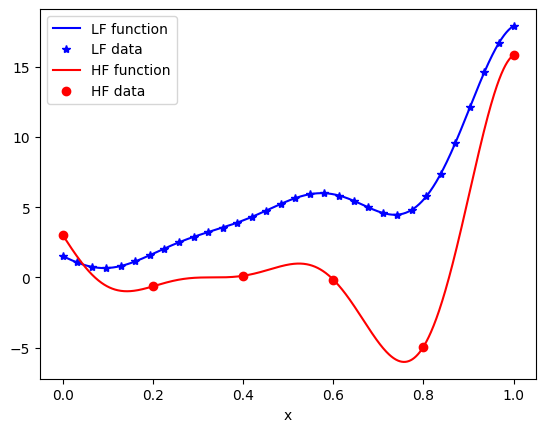

In [2]:
## Define benchmark functions

# Linear correlation benchmark
highfid = lambda x: (6.*x-2.)**2*np.sin(12.*x-4.)
lowfid  = lambda x: 0.5*highfid(x) + 10*(x-0.5) + 5.

# Discontinuous and nonlinear correlation benchmark
#lowfid = lambda x: (0.5*(6.*x-2.)**2*np.sin(12.*x-4)+10.*(x-0.5)-5.)*(x<0.5) + (3+0.5*(6.*x-2)**2*np.sin(12.*x-4)+10*(x-0.5)-5.)*(x>0.5)
#highfid = lambda x: (2*lowfid(x)- 20*x+20)*(x<0.5) + (4+2*lowfid(x)- 20*x+20)*(x>0.5)


## Generate data
Nhf = 6   # Number of HF points
Nlf = 32  # Number of LF points
xhf = np.linspace(0, 1, Nhf)
xlf = np.linspace(0, 1, Nlf)

Yhf = highfid(xhf)
Ylf = lowfid(xlf)


## Test data
x_test = np.linspace(0, 1, 1000)
Yhf_test = highfid(x_test)


## Normalize data
x_big = np.linspace(0, 1, 1000000)
hfmean = np.mean(highfid(x_big))
lfmean = np.mean(lowfid(x_big))

Yhf = Yhf - hfmean
Ylf = Ylf - lfmean
Yhf_test = Yhf_test - hfmean


## Plot functions
plt.figure()
plt.plot(x_test, lowfid(x_test), 'b-', label = 'LF function')
plt.plot(xlf, lowfid(xlf), 'b*', label = 'LF data')
plt.plot(x_test, highfid(x_test), 'r-', label = 'HF function')
plt.plot(xhf, highfid(xhf), 'ro', label = 'HF data')
plt.xlabel('x')
plt.legend()
plt.show()

In [3]:
# Single LF Network

modelLF = (
    ("dense1", Dense(layer_width=64, activation="tanh", parameter_sampler="tanh", random_seed=10)),
    ("dense2", Dense(layer_width=64, activation="tanh", parameter_sampler="tanh", random_seed=10)),
    ("dense3", Dense(layer_width=64, activation="tanh", parameter_sampler="tanh", random_seed=10)),
    ("linear", Linear(regularization_scale=1e-4))
)

modelLF = Pipeline(modelLF)
modelLF.fit(xlf.reshape(-1, 1), Ylf.reshape(-1, 1))

yLF = modelLF.transform(x_test.reshape(-1,1))[:,0]

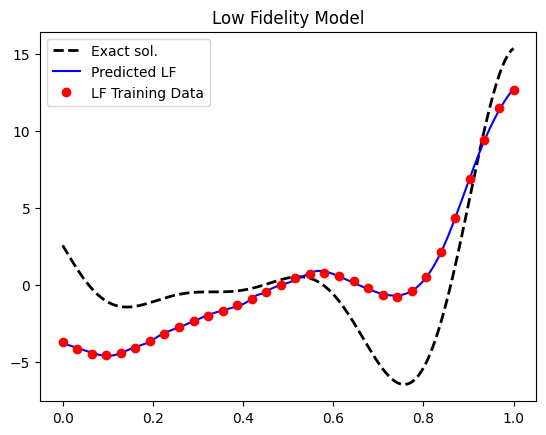

In [4]:
# Plot LF results
plt.figure()
plt.plot(x_test, Yhf_test, 'k--', label = 'Exact sol.', linewidth = 2)
plt.plot(x_test, yLF, 'b-', label='Predicted LF')
plt.plot(xlf, Ylf, 'ro', label='LF Training Data')
plt.legend()
plt.title('Low Fidelity Model')
plt.show()

In [5]:
# Single HF Network

modelHF = (
    ("dense1", Dense(layer_width=32, activation="tanh", parameter_sampler="tanh", random_seed=10)),
    ("linear", Linear(regularization_scale=1e-4))
)

modelHF = Pipeline(modelHF)
modelHF.fit(xhf.reshape(-1, 1), Yhf.reshape(-1, 1))

yHF = modelHF.transform(x_test.reshape(-1,1))[:,0]

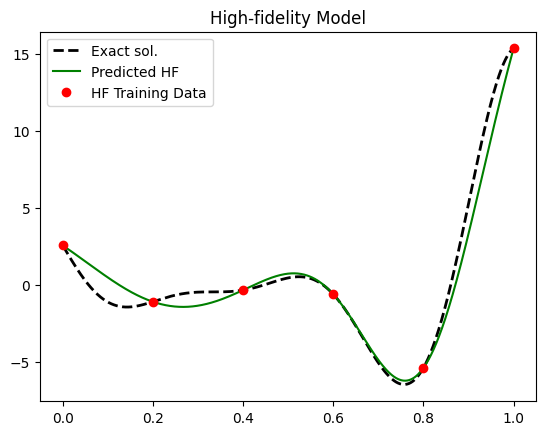

In [6]:
# Plot HF results
plt.figure()
plt.plot(x_test, Yhf_test, 'k--', label = 'Exact sol.', linewidth = 2)
plt.plot(x_test, yHF, 'g-', label='Predicted HF')
plt.plot(xhf, Yhf, 'ro', label='HF Training Data')
plt.legend()
plt.title('High-fidelity Model')
plt.show()

In [7]:
# Evalute the LF model at the HF inputs
xhf_help = modelLF.predict(xhf.reshape(-1,1))[:, 0]

# Create the inputs by stacking the HF inputs with the corresponding LF predictions
xmf = np.vstack((xhf, xhf_help)).transpose()

# Do the same for the test data
x_test_help = modelLF.predict(x_test.reshape(-1,1))[:, 0]
x_test_in = np.vstack((x_test, x_test_help)).transpose()

In [8]:
# Define the MF 2-step model and compile it

modelMF = (
    ("dense1", Dense(layer_width=32, activation="tanh", parameter_sampler="tanh", random_seed=10 )),
    ("linear", Linear(regularization_scale=1e-4))
)

modelMF = Pipeline(modelMF)
modelMF.fit(xmf, Yhf.reshape(-1, 1))


# Evaluate the HF model on the test set
yMF = modelMF.transform(x_test_in)[:,0]

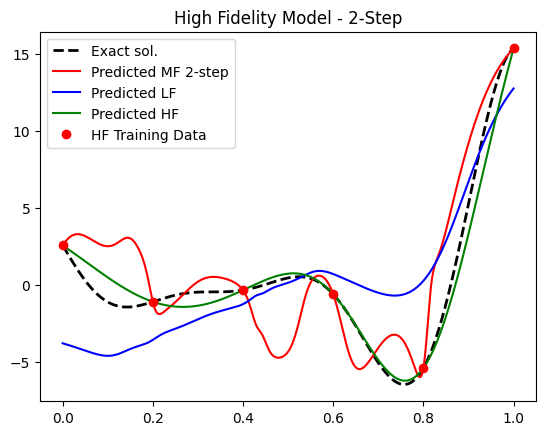

In [9]:
# Plot results
plt.figure()
plt.plot(x_test, Yhf_test, '--k', label='Exact sol.', linewidth = 2)
plt.plot(x_test, yMF, 'r-', label='Predicted MF 2-step')
plt.plot(x_test, yLF, 'b-', label = 'Predicted LF')
plt.plot(x_test, yHF, 'g-', label = 'Predicted HF')
plt.plot(xhf, Yhf, 'ro', label='HF Training Data')

plt.legend()
plt.title('High Fidelity Model - 2-Step')
plt.show()

In [10]:
# Print percentage errors for LF, HF and MF
print('LF error: ', np.linalg.norm(yLF - Yhf_test)/np.linalg.norm(Yhf_test)*100, '%')
print('HF error: ', np.linalg.norm(yHF - Yhf_test)/np.linalg.norm(Yhf_test)*100, '%')
print('MF error: ', np.linalg.norm(yMF - Yhf_test)/np.linalg.norm(Yhf_test)*100, '%')

LF error:  70.08478622034386 %
HF error:  20.628605032992265 %
MF error:  59.88786956470623 %


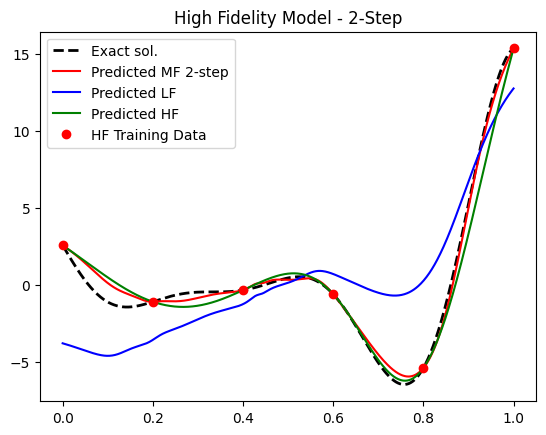

In [11]:
# Evalute the LF model at the HF inputs
xhf_help = modelLF.predict(xhf.reshape(-1,1))[:, 0]

# Crea input xmf per MF model (HF input + LF predizione)
xmf = np.vstack((xhf, xhf_help)).T  # shape: (Nhf, 2)

# Crea input x_test_in analogamente per il test set
x_test_help = modelLF.predict(x_test.reshape(-1,1))[:, 0]
x_test_in = np.vstack((x_test, x_test_help)).T  # shape: (n_test, 2)

# 🔁 Normalizzazione (fit solo sui dati di training)
xmf_mean = np.mean(xmf, axis=0)
xmf_std = np.std(xmf, axis=0)

xmf_norm = (xmf - xmf_mean) / xmf_std
x_test_in_norm = (x_test_in - xmf_mean) / xmf_std

# 🚀 Definizione e training del modello MF
modelMF = (
    ("dense1", Dense(layer_width=32, activation="tanh", parameter_sampler="tanh", random_seed=10)),
    ("linear", Linear(regularization_scale=1e-4))  # puoi provare anche 1e-3, 1e-2 se vuoi più regolarizzazione
)

modelMF = Pipeline(modelMF)
modelMF.fit(xmf_norm, Yhf.reshape(-1, 1))  # Allenamento sul dato normalizzato

# 📈 Predizione sul test set normalizzato
yMF = modelMF.transform(x_test_in_norm)[:, 0]

# Plot results
plt.figure()
plt.plot(x_test, Yhf_test, '--k', label='Exact sol.', linewidth = 2)
plt.plot(x_test, yMF, 'r-', label='Predicted MF 2-step')
plt.plot(x_test, yLF, 'b-', label = 'Predicted LF')
plt.plot(x_test, yHF, 'g-', label = 'Predicted HF')
plt.plot(xhf, Yhf, 'ro', label='HF Training Data')

plt.legend()
plt.title('High Fidelity Model - 2-Step')
plt.show()

In [12]:
# Print percentage errors for LF, HF and MF
print('LF error: ', np.linalg.norm(yLF - Yhf_test)/np.linalg.norm(Yhf_test)*100, '%')
print('HF error: ', np.linalg.norm(yHF - Yhf_test)/np.linalg.norm(Yhf_test)*100, '%')
print('MF error: ', np.linalg.norm(yMF - Yhf_test)/np.linalg.norm(Yhf_test)*100, '%')

LF error:  70.08478622034386 %
HF error:  20.628605032992265 %
MF error:  11.164866323860343 %
